In [1]:
import sys
sys.path.append('../pde_nn')
import models.channel_flow as chan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
torch.random.manual_seed(123)

In [2]:
# overall hypers
hypers = chan.get_hyperparams(ymin=-1, ymax=1, batch_size=1000)
# constructions from hypers
y = np.linspace(hypers['ymin'], hypers['ymax'], hypers['batch_size'])
delta = (hypers['ymax']-hypers['ymin'])/2
reynolds_stress = chan.get_mixing_len_model(hypers['k'], delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])

In [6]:
# DNS + Numerical Data
dns_retau180 = pd.read_csv('data/LM_Channel_Retau180.txt', delimiter=' ')
numerical_u180 = np.load('data/mixlen_numerical_u180.npy')
# setting nu for Retau 180
hypers['nu']=0.0055555555
retau=chan.calc_retau(delta, hypers['dp_dx'], hypers['rho'], hypers['nu'])
print('Retau = {}'.format(retau))
# converting DNS data
half_u180,  half_y180 = chan.convert_dns(delta, hypers, dns_retau180)

Retau = 180.0000018


In [7]:
def expose_results(folder_timestamp):
    # load everything from disk
    preds = np.load('data/{}/mixlen_preds_u180.0.npy'.format(folder_timestamp))
    losses = np.load('data/{}/mixlen_loss_u180.0.npy'.format(folder_timestamp))
    hypers = np.load('data/{}/mixlen_hypers_u180.0.npy'.format(folder_timestamp))
    hypers = hypers.item()
    pdenn = chan.Chanflow(num_units=hypers['num_units'], num_layers=hypers['num_layers'])
    pdenn.load_state_dict(torch.load('data/{}/mixlen_model_u180.0.pt'.format(folder_timestamp)))
    
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    chan.make_plots(ax, losses[:,0], pdenn, hypers, retau)
    chan.plot_dns(ax[1], half_u180, half_y180, delta)
    ax[0].plot(np.arange(losses.shape[0]), losses[:,1], color='orange', alpha=0.6, label='val')
    ax[0].legend()
    ax[1].plot(numerical_u180, y, label='FD', color='black')
    ax[1].legend()
    
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    ax.plot(preds, y, 'o', label='NN', color='blue', alpha=1, markersize=0.5, linewidth=1)
    # ax.plot(numerical_u180, y, label='FD', color='black')
    ax.set_title('$<U>$ @ Re_tau = {}'.format(retau))
    ax.set_xlabel('$<U>$')
    ax.set_ylabel('$y$')
    ax.legend()
    
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    chan.loss_vs_distance(ax[0,0],  -1, 1, pdenn, hypers, reynolds_stress)
    chan.loss_vs_distance(ax[0,1], -.5, .5, pdenn, hypers, reynolds_stress)
    chan.loss_vs_distance(ax[1,0], .8, 1, pdenn, hypers, reynolds_stress)
    chan.loss_vs_distance(ax[1,1], .99, 1, pdenn, hypers, reynolds_stress)
    
    plt.show()

## $Re_{\tau} = 180$ and same 1000 pts, linspace, 100K iters

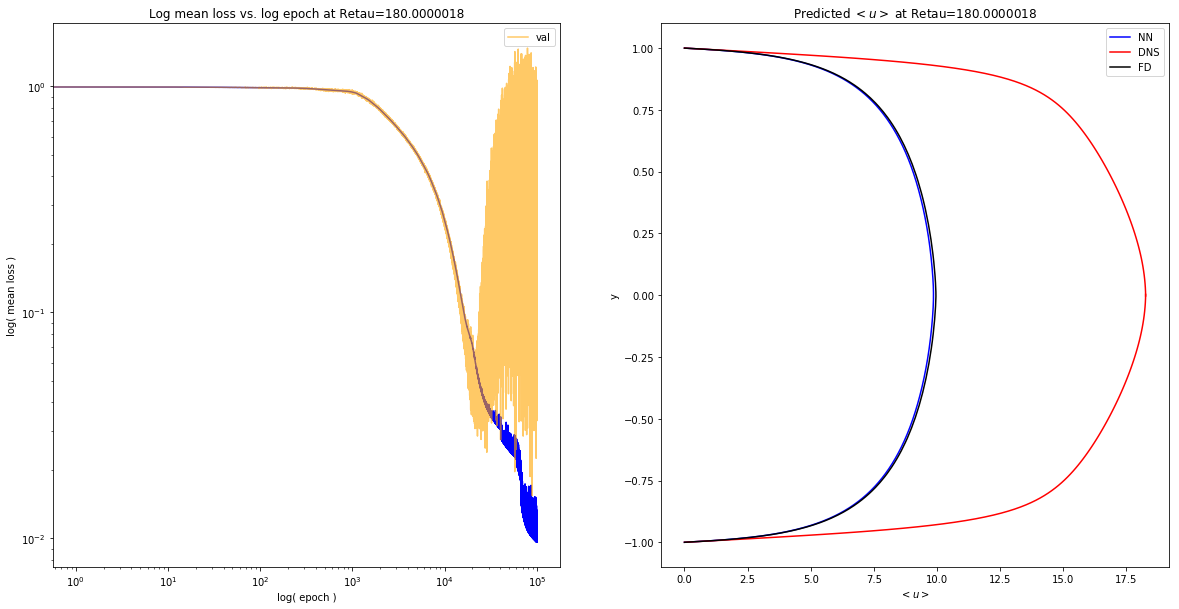

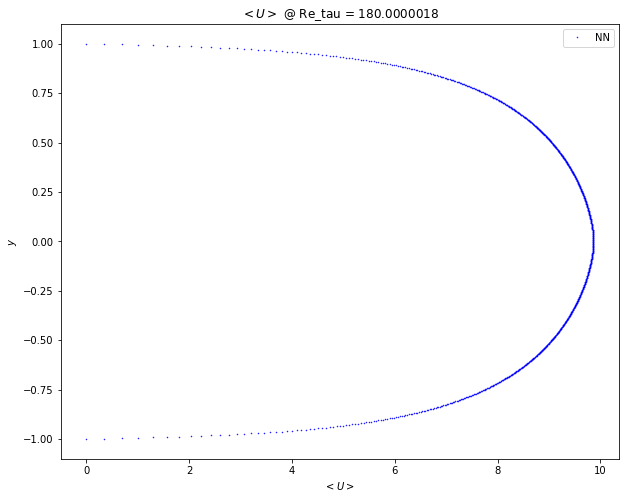

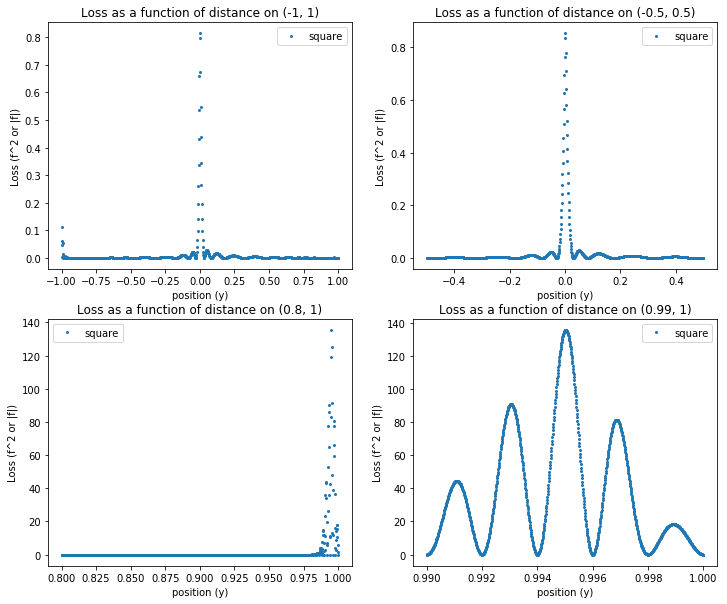

In [8]:
expose_results('1550163047.376538')